## Install Kaggle Library

In [1]:
# Install the Kaggle library
!pip install kaggle

## Import Libraries

In [2]:
# Import necessary libraries
from google.colab import userdata
import os
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

## Set Kaggle API Credentials and Download Dataset

In [3]:
# Set Kaggle API credentials
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [4]:
# Use the Kaggle CLI to download the dataset
!kaggle datasets download -d frabbisw/facial-age

 99% 835M/840M [00:11<00:00, 59.6MB/s]
100% 840M/840M [00:11<00:00, 74.3MB/s]


In [6]:
# Extract the zipfile
zip_file_path = "facial-age.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("path/to/extract")

## Explore and Display Dataset

In [8]:
path = '/content/path/to/extract/face_age'

In [9]:
# List all files in the directory
file_list = os.listdir(path)

# Filter out directories that represent ages (assumed to be numeric directories)
age_files = [f"{path}/{file}" for file in file_list if file.isdigit()]

# Sort the age directories
age_files.sort()

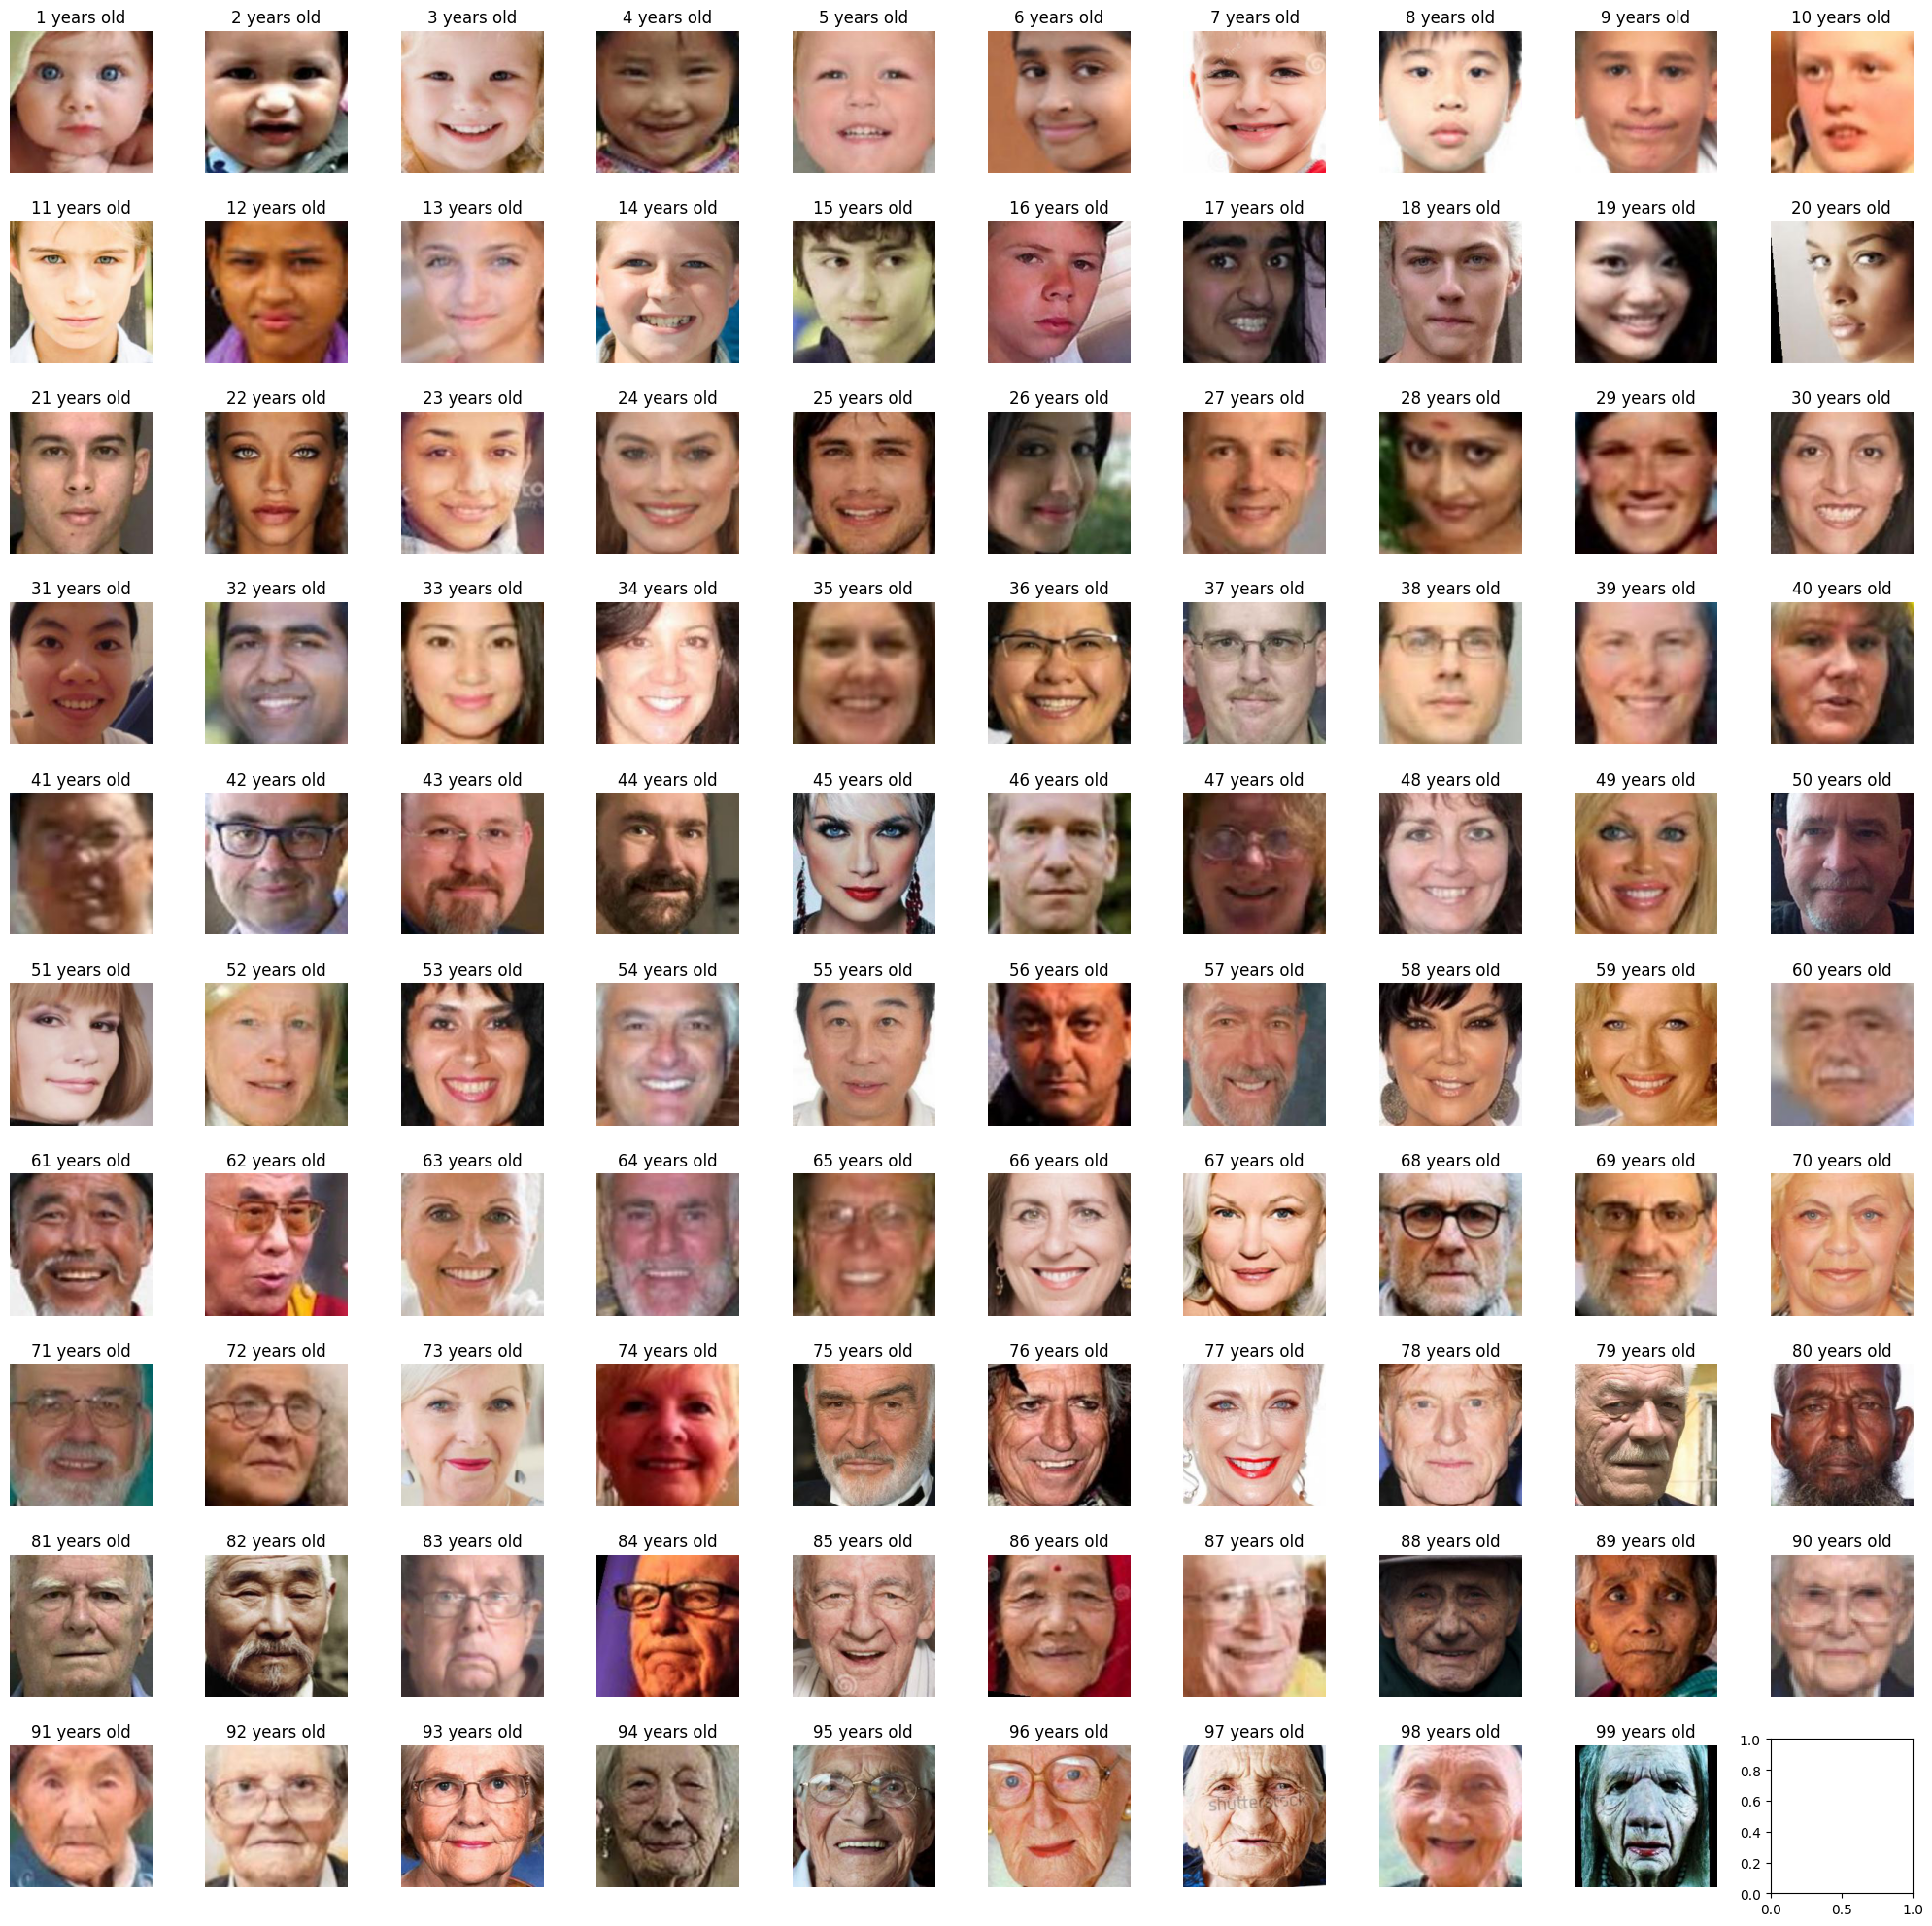

In [10]:
# Create a 10x10 grid of subplots for displaying images
_, axes = plt.subplots(10, 10, figsize=(20, 20))

# Iterate over the first 100 age directories and display the first image from each
for i, age_path in enumerate(age_files, 1):
    # List image files in the current age directory
    age_images = [f"{age_path}/{image}" for image in os.listdir(age_path) if image.endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp'))]
    if age_images:
        # Read the first image from the current age directory
        img = mpimg.imread(age_images[0])
        # Display the image on the corresponding subplot
        axes[(i-1)//10, (i-1)%10].imshow(img)
        # Turn off axis labels
        axes[(i-1)//10, (i-1)%10].axis('off')
        # Set the title of the subplot to indicate the age
        axes[(i-1)//10, (i-1)%10].set_title(f"{i} years old")
    # Break the loop if 100 age directories have been processed
    if i == 100:
        break

plt.tight_layout()
plt.show()

## Data Preprocessing

In [12]:
X = []
y = []

In [13]:
path = '/content/path/to/extract/face_age'

In [14]:
file_list = os.listdir(path)

age_paths = [os.path.join(path, file) for file in file_list if file.isdigit()]
age_paths.sort()

In [15]:
for i, age_path in enumerate(age_paths, 1):
    imgs = [img for img in os.listdir(age_path)]

    for img in imgs:
        image = Image.open(os.path.join(age_path, img))
        resized_image = image.resize((128, 128))

        # Convert the grayscale image to a numpy array
        image_data = np.array(resized_image)

        if i > 0 and i <= 3:
          y.append(0)
        elif i > 3 and i <= 8:
          y.append(1)
        elif i > 9 and i <= 14:
          y.append(2)
        elif i > 15 and i <= 19:
          y.append(3)
        elif i > 20 and i <= 34:
          y.append(4)
        elif i > 35 and i <= 44:
          y.append(5)
        elif i > 45 and i <= 64:
          y.append(6)
        else:
          y.append(7)
        X.append(image_data)

In [16]:
X = np.array(X)
y = np.array(y)

array([[[153, 159, 113],
        [153, 159, 113],
        [153, 159, 113],
        ...,
        [ 32,  13,   4],
        [ 29,  13,   5],
        [ 27,  14,   5]],

       [[153, 159, 113],
        [153, 159, 113],
        [153, 159, 113],
        ...,
        [ 35,  15,   6],
        [ 31,  15,   7],
        [ 30,  17,   8]],

       [[154, 160, 113],
        [154, 160, 113],
        [154, 160, 113],
        ...,
        [ 39,  16,   8],
        [ 34,  18,   9],
        [ 31,  19,  10]],

       ...,

       [[126,  64,  49],
        [126,  64,  49],
        [126,  65,  49],
        ...,
        [195, 155, 145],
        [196, 156, 146],
        [197, 157, 147]],

       [[124,  62,  47],
        [125,  63,  48],
        [125,  64,  48],
        ...,
        [197, 157, 147],
        [197, 157, 147],
        [198, 158, 148]],

       [[122,  60,  45],
        [124,  62,  47],
        [124,  63,  47],
        ...,
        [199, 160, 151],
        [200, 161, 152],
        [200, 161, 152]]], dtype=uint8)
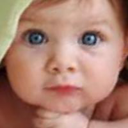

In [17]:
X[0]

## Split Data into Training and Testing Sets

In [18]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.35, random_state= 22)

## Image Data Augmentation

In [19]:
from keras.preprocessing.image import ImageDataGenerator

In [20]:
datagen = ImageDataGenerator(
    rotation_range=10,      # Rotation angle in degrees
    width_shift_range=0.1,  # Shift range as a fraction of total width
    height_shift_range=0.1, # Shift range as a fraction of total height
    shear_range=0.2,        # Shear intensity
    zoom_range=0.1,         # Range for random zoom
    horizontal_flip=True,   # Randomly flip inputs horizontally
    vertical_flip=False,    # Randomly flip inputs vertically
    fill_mode='nearest'     # How to fill in newly created pixels
)

In [21]:
# Fit the data generator on the training data
datagen.fit(X_train)

In [22]:
# Generate augmented data
augmented_data_generator = datagen.flow(X_train, y_train, batch_size=32)

## Define and Compile CNN Model

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [24]:
# Define your CNN model for grayscale images
def create_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [25]:
# Define input shape and number of classes
input_shape = (128, 128, 3)  # Example input shape for grayscale images
num_classes = 8  # Number of different types of pictures

In [26]:
# Create the model
model = create_model(input_shape, num_classes)

In [27]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 50176)             0

## Train the Model

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
epochs = 50

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/20
198/198 [==============================] - 37s 163ms/step - loss: 1.1824 - accuracy: 0.5483 - val_loss: 1.1791 - val_accuracy: 0.5600
Epoch 2/20
198/198 [==============================] - 28s 143ms/step - loss: 1.2022 - accuracy: 0.5346 - val_loss: 1.1934 - val_accuracy: 0.5513
Epoch 3/20
198/198 [==============================] - 28s 142ms/step - loss: 1.2064 - accuracy: 0.5395 - val_loss: 1.1750 - val_accuracy: 0.5676
Epoch 4/20
198/198 [==============================] - 31s 159ms/step - loss: 1.1703 - accuracy: 0.5463 - val_loss: 1.1540 - val_accuracy: 0.5703
Epoch 5/20
198/198 [==============================] - 28s 143ms/step - loss: 1.1617 - accuracy: 0.5534 - val_loss: 1.1648 - val_accuracy: 0.5781
Epoch 6/20
198/198 [==============================] - 28s 143ms/step - loss: 1.1820 - accuracy: 0.5447 - val_loss: 1.1902 - val_accuracy: 0.5501
Epoch 7/20
198/198 [==============================] - 29s 148ms/step - loss: 1.1603 - accuracy: 0.5539 - val_loss: 1.1612 - val_ac

## Save the Trained Model

In [ ]:
model.save("weights/model.h5")

## Load the Trained Model and Make Predictions

In [ ]:
# from keras.models import load_model
# model = load_model("weights/model.h5")

In [ ]:
ages = ['1-3','4-8', '9-14','15-19', '20-34', '35-44','45-64', '65-110']
image = Image.open(os.path.join("test.jpg"))

In [ ]:
# Resize the image to 128x128
resized_image = image.resize((128, 128))

## Test the Trained Model

array([[[102, 102, 116],
        [107, 109, 122],
        [120, 123, 136],
        ...,
        [105, 111, 124],
        [104, 111, 127],
        [104, 111, 126]],

       [[107, 107, 121],
        [113, 114, 128],
        [124, 127, 139],
        ...,
        [106, 112, 125],
        [105, 112, 128],
        [106, 112, 127]],

       [[112, 112, 126],
        [117, 119, 132],
        [123, 126, 138],
        ...,
        [111, 117, 129],
        [110, 116, 129],
        [110, 116, 129]],

       ...,

       [[ 85,  79,  84],
        [ 83,  78,  84],
        [ 76,  73,  78],
        ...,
        [ 59,  58,  65],
        [ 53,  49,  57],
        [ 51,  46,  53]],

       [[ 83,  79,  83],
        [ 80,  77,  82],
        [ 75,  72,  77],
        ...,
        [ 55,  54,  61],
        [ 48,  45,  53],
        [ 47,  43,  50]],

       [[ 81,  78,  81],
        [ 79,  75,  81],
        [ 75,  72,  77],
        ...,
        [ 51,  50,  57],
        [ 45,  42,  50],
        [ 45,  41,  49]]], dtype=uint8)
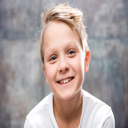

In [ ]:
# Convert the grayscale image to a numpy array
image = np.array(resized_image)
image

## Evaluate the Trained Model

In [ ]:
image = np.expand_dims(image, axis=0)
predictions = model.predict(image)
predicted_class_index = np.argmax(predictions)
print(ages[predicted_class_index])

1/1 [==============================] - 0s 68ms/step
45-64
